In [1]:
import os
import re
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from tqdm import tqdm
import traceback

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("✅ Imports successful")

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ Imports successful


In [5]:
DATASET_DIR = "./sample_dataset"
VIDEO_DIR = os.path.join(DATASET_DIR, "videos")
META_PATH = os.path.join(DATASET_DIR, "sampled_metadata.csv")

# OUTPUT
OUTPUT_DIR = "./features/pose_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)
GLOBAL_STATS_PATH = "./proc/global_stats.npz"
os.makedirs(os.path.dirname(GLOBAL_STATS_PATH), exist_ok=True)

# FEATURE DIMENSIONS
FACE_DOWNSAMPLE = 5  # Sample every 5th face landmark
NUM_FACE_LANDMARKS = len(range(0, 468, FACE_DOWNSAMPLE))  # = 94
NUM_POSE_LANDMARKS = 33
NUM_HAND_LANDMARKS = 21

# Calculate per-frame feature length
POSE_FEATURES = NUM_POSE_LANDMARKS * 4          # x, y, z, visibility
HANDS_FEATURES = 2 * NUM_HAND_LANDMARKS * 3     # left + right hands
FACE_FEATURES = NUM_FACE_LANDMARKS * 3          # downsampled face
PER_FRAME_FEATURES = POSE_FEATURES + HANDS_FEATURES + FACE_FEATURES

# QUALITY HEURISTICS & TARGET SHAPES
TARGET_SEQ_LEN = 64
MODEL_COMPLEXITY = 2
MIN_FRAMES = 48
MIN_VALID_RATIO = 0.45
EMA_ALPHA = 0.2  # Exponential smoothing factor for temporal jitter
VISIBILITY_THRESHOLD = 0.55
MOTION_KEEP_THRESHOLD = 1e-3
MOTION_REJECTION_THRESHOLD = 7.5e-4
KEEP_LOW_QUALITY = False  # Flip to True to keep flagged clips for manual review

# Landmark indices for torso-centric normalization
LEFT_SHOULDER = 11
RIGHT_SHOULDER = 12
LEFT_HIP = 23
RIGHT_HIP = 24

print("📐 Feature dimensions:")
print(f"  • Pose: {POSE_FEATURES} (33 landmarks × 4)")
print(f"  • Hands: {HANDS_FEATURES} (2 hands × 21 landmarks × 3)")
print(f"  • Face: {FACE_FEATURES} (94 landmarks × 3)")
print(f"  • TOTAL per frame: {PER_FRAME_FEATURES}")
print("⚙️  Quality thresholds")
print(f"  • min_frames: {MIN_FRAMES}")
print(f"  • min_valid_ratio: {MIN_VALID_RATIO}")
print(f"  • visibility min: {VISIBILITY_THRESHOLD}")
print(f"  • motion keep ≥ {MOTION_KEEP_THRESHOLD:.1e}")
print(f"  • motion reject < {MOTION_REJECTION_THRESHOLD:.1e}")
print(f"🧱  Model complexity: {MODEL_COMPLEXITY}")
print(f"📊  Global stats path: {GLOBAL_STATS_PATH}")

📐 Feature dimensions:
  • Pose: 132 (33 landmarks × 4)
  • Hands: 126 (2 hands × 21 landmarks × 3)
  • Face: 282 (94 landmarks × 3)
  • TOTAL per frame: 540
⚙️  Quality thresholds
  • min_frames: 48
  • min_valid_ratio: 0.45
  • visibility min: 0.55
  • motion keep ≥ 1.0e-03
  • motion reject < 7.5e-04
🧱  Model complexity: 2
📊  Global stats path: ./proc/global_stats.npz


In [4]:
# WORKAROUND CELL - Manual CSV parsing
import csv

META_PATH = "./sample_dataset/sampled_metadata.csv"

# Read CSV manually to avoid pandas parsing issues
records = []
with open(META_PATH, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        records.append(row)

# Convert to DataFrame manually
df_meta = pd.DataFrame(records)

# Convert sentence_id to int
df_meta['sentence_id'] = df_meta['sentence_id'].astype(int)

print(f"✅ Loaded metadata: {len(df_meta)} videos")
print(f"📋 Columns: {df_meta.columns.tolist()}")
print(f"📊 Unique sentences: {df_meta['sentence_id'].nunique()}")
print(f"📋 Categories: {df_meta['category'].nunique()}")

print("\n📝 Sample rows:")
print(df_meta.head())

✅ Loaded metadata: 1500 videos
📋 Columns: ['video_file', 'sentence_id', 'sentence', 'category', 'variant']
📊 Unique sentences: 1322
📋 Categories: 27

📝 Sample rows:
  video_file  sentence_id                              sentence  \
0     6C.mp4            6            Where is the waiting area?   
1     7A.mp4            7  What floor is the pediatric ward on?   
2    12C.mp4           12          What are the visiting hours?   
3    13D.mp4           13             Can I see the doctor now?   
4    14D.mp4           14           Is this the maternity ward?   

                        category variant  
0  General hospital interactions       C  
1  General hospital interactions       A  
2  General hospital interactions       C  
3  General hospital interactions       D  
4  General hospital interactions       D  


In [ ]:
mp_holistic = mp.solutions.holistic

# Global Holistic instance for worker processes (initialized in worker_init)
HOLISTIC = None
FACE_INDICES = list(range(0, 468, FACE_DOWNSAMPLE))


def worker_init(face_downsample: int = FACE_DOWNSAMPLE):
    """Initializer for Pool worker processes: creates a global MediaPipe Holistic instance
    and precomputes face landmark indices. This avoids recreating the model per video.
    """
    global HOLISTIC, FACE_INDICES
    try:
        HOLISTIC = mp_holistic.Holistic(
            static_image_mode=False,
            model_complexity=MODEL_COMPLEXITY,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5,
        )
    except Exception:
        HOLISTIC = None
    FACE_INDICES = list(range(0, 468, max(1, int(face_downsample))))


def normalize_frame_landmarks(frame_feats):
    """Center and scale landmarks around the torso to reduce camera variance.

    Optimized to use local variables and avoid repeated attribute lookups.
    Returns a 1D np.float32 vector length PER_FRAME_FEATURES.
    """
    feats = np.asarray(frame_feats, dtype=np.float32)

    # Pose block (33 x 4)
    pose = feats[:POSE_FEATURES].reshape(NUM_POSE_LANDMARKS, 4)

    lh_start = POSE_FEATURES
    lh_end = lh_start + NUM_HAND_LANDMARKS * 3
    rh_end = lh_end + NUM_HAND_LANDMARKS * 3

    left_hand = feats[lh_start:lh_end].reshape(NUM_HAND_LANDMARKS, 3)
    right_hand = feats[lh_end:rh_end].reshape(NUM_HAND_LANDMARKS, 3)
    face = feats[rh_end:rh_end + NUM_FACE_LANDMARKS * 3].reshape(NUM_FACE_LANDMARKS, 3)

    pose_coords = pose[:, :3].copy()

    torso_pts = pose_coords[[LEFT_SHOULDER, RIGHT_SHOULDER, LEFT_HIP, RIGHT_HIP]]

    # Validate torso points
    if not np.isfinite(torso_pts).all() or np.linalg.norm(torso_pts) < 1e-6:
        return feats.astype(np.float32)

    torso_center = torso_pts.mean(axis=0)

    # Subtract center in-place on local arrays
    pose_coords -= torso_center
    left_hand -= torso_center
    right_hand -= torso_center
    face -= torso_center

    # Compute scale robustly using median of candidate spans
    shoulder_span = np.linalg.norm(pose_coords[LEFT_SHOULDER] - pose_coords[RIGHT_SHOULDER])
    hip_span = np.linalg.norm(pose_coords[LEFT_HIP] - pose_coords[RIGHT_HIP])
    shoulder_center = 0.5 * (pose_coords[LEFT_SHOULDER] + pose_coords[RIGHT_SHOULDER])
    hip_center = 0.5 * (pose_coords[LEFT_HIP] + pose_coords[RIGHT_HIP])
    torso_height = np.linalg.norm(shoulder_center - hip_center)

    candidates = [c for c in (shoulder_span, hip_span, torso_height) if c > 1e-4]
    scale = float(np.median(candidates)) if candidates else 1.0
    if scale < 1e-6:
        scale = 1.0

    inv_scale = 1.0 / scale
    # Apply scale via multiplication (faster than repeated division)
    pose_coords *= inv_scale
    left_hand *= inv_scale
    right_hand *= inv_scale
    face *= inv_scale

    # Put back into pose structure
    pose[:, :3] = pose_coords

    normalized = np.concatenate([
        pose.reshape(-1),
        left_hand.reshape(-1),
        right_hand.reshape(-1),
        face.reshape(-1),
    ]).astype(np.float32)

    return normalized


def exponential_smooth(sequence: np.ndarray, alpha: float = EMA_ALPHA) -> np.ndarray:
    """Exponential moving average implemented using an efficient in-place loop.

    For short sequences this loop is inexpensive; vectorized alternatives require
    external dependencies (scipy) so we keep this simple and avoid allocations.
    """
    seq = sequence.astype(np.float32, copy=False)
    n = seq.shape[0]
    if alpha <= 0.0 or n < 2:
        return seq

    out = seq.copy()
    one_minus = 1.0 - alpha
    # operate per-row to keep memory locality
    for i in range(1, n):
        out[i] = alpha * seq[i] + one_minus * out[i - 1]
    return out


def compute_motion_energy(frames: np.ndarray) -> np.ndarray:
    """Compute per-frame motion energy from frame-to-frame deltas.

    Optimizations:
    - Uses numpy vectorized diffs
    - Avoids recomputing slice offsets repeatedly
    """
    if frames.shape[0] == 0:
        return np.zeros((0,), dtype=np.float32)

    # Pose xyz: first POSE_FEATURES entries contain 33*(x,y,z,vis)
    pose_xyz = frames[:, :POSE_FEATURES].reshape(frames.shape[0], NUM_POSE_LANDMARKS, 4)[..., :3]
    pose_flat = pose_xyz.reshape(frames.shape[0], -1)

    hands = frames[:, POSE_FEATURES:POSE_FEATURES + 2 * NUM_HAND_LANDMARKS * 3]
    face = frames[:, POSE_FEATURES + 2 * NUM_HAND_LANDMARKS * 3:]

    coords = np.concatenate([pose_flat, hands, face], axis=1)

    # frame-to-frame differences (prepend first row to keep same length)
    diffs = np.diff(coords, axis=0, prepend=coords[:1])
    energy = np.linalg.norm(diffs, axis=1)
    return energy.astype(np.float32)


def summarize_motion(values: np.ndarray) -> dict:
    if values.size == 0:
        return {"mean": 0.0, "p50": 0.0, "p95": 0.0, "max": 0.0}
    return {
        "mean": float(values.mean()),
        "p50": float(np.median(values)),
        "p95": float(np.percentile(values, 95)),
        "max": float(values.max()),
    }


def trim_or_pad_sequence(sequence: np.ndarray, target_len: int = TARGET_SEQ_LEN) -> np.ndarray:
    """Center-crop or pad a sequence to the target length (unchanged behavior)."""
    frames = sequence.shape[0]
    if frames == target_len:
        return sequence
    if frames > target_len:
        start = (frames - target_len) // 2
        return sequence[start:start + target_len]
    pad_len = target_len - frames
    pad = np.zeros((pad_len, sequence.shape[1]), dtype=sequence.dtype)
    return np.vstack([sequence, pad])


print("✅ Feature extraction helpers ready (optimized)")

✅ Feature extraction helpers ready


In [ ]:
from functools import partial
import atexit

# Ensure worker HOLISTIC is closed on process exit
def _close_holistic():
    global HOLISTIC
    try:
        if HOLISTIC is not None:
            HOLISTIC.close()
    except Exception:
        pass

atexit.register(_close_holistic)


def process_single_video(row_dict, video_dir, output_dir, face_downsample):
    """Process a single video, enforcing quality thresholds.

    Uses a per-process global `HOLISTIC` instance when available (created by
    `worker_init`). Falls back to a local instance for single-process runs.
    """
    import os

    video_file = row_dict['video_file']
    video_path = os.path.join(video_dir, video_file)

    if not os.path.exists(video_path):
        return {
            'status': 'missing',
            'video_file': video_file,
            'error': 'File not found'
        }

    local_holistic = None
    holistic_inst = HOLISTIC
    try:
        # Fallback: create a local holistic if worker initializer wasn't used
        if holistic_inst is None:
            local_holistic = mp_holistic.Holistic(
                static_image_mode=False,
                model_complexity=MODEL_COMPLEXITY,
                min_detection_confidence=0.5,
                min_tracking_confidence=0.5,
            )
            holistic_inst = local_holistic

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return {'status': 'failed', 'video_file': video_file, 'error': 'Cannot open video'}

        frames_features = []
        quality_flags = []
        pose_vis_scores = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = holistic_inst.process(frame_rgb)

            # Build frame feature vector using preallocated list and local variables
            frame_feats = [0.0] * PER_FRAME_FEATURES
            off = 0

            if result.pose_landmarks:
                for lm in result.pose_landmarks.landmark:
                    frame_feats[off] = lm.x; frame_feats[off + 1] = lm.y; frame_feats[off + 2] = lm.z; frame_feats[off + 3] = getattr(lm, 'visibility', 0.0)
                    off += 4
                pose_visibility = float(np.mean([getattr(lm, 'visibility', 0.0) for lm in result.pose_landmarks.landmark]))
            else:
                off += NUM_POSE_LANDMARKS * 4
                pose_visibility = 0.0

            # Left hand
            if result.left_hand_landmarks:
                for lm in result.left_hand_landmarks.landmark:
                    frame_feats[off] = lm.x; frame_feats[off + 1] = lm.y; frame_feats[off + 2] = lm.z
                    off += 3
            else:
                off += NUM_HAND_LANDMARKS * 3

            # Right hand
            if result.right_hand_landmarks:
                for lm in result.right_hand_landmarks.landmark:
                    frame_feats[off] = lm.x; frame_feats[off + 1] = lm.y; frame_feats[off + 2] = lm.z
                    off += 3
            else:
                off += NUM_HAND_LANDMARKS * 3

            # Face downsampled
            if result.face_landmarks:
                fl = result.face_landmarks.landmark
                for i in range(0, 468, face_downsample):
                    lm = fl[i]
                    frame_feats[off] = lm.x; frame_feats[off + 1] = lm.y; frame_feats[off + 2] = lm.z
                    off += 3
            else:
                off += NUM_FACE_LANDMARKS * 3

            # Safety: trim/pad
            if off > PER_FRAME_FEATURES:
                frame_feats = frame_feats[:PER_FRAME_FEATURES]

            # Normalize around torso to reduce camera variance
            frame_array = normalize_frame_landmarks(frame_feats)

            has_pose = result.pose_landmarks is not None
            has_hands = (result.left_hand_landmarks is not None) or (result.right_hand_landmarks is not None)

            frames_features.append(frame_array)
            quality_flags.append(has_pose or has_hands)
            pose_vis_scores.append(pose_visibility)

        cap.release()

        total_frames = len(frames_features)
        if total_frames == 0:
            return {'status': 'failed', 'video_file': video_file, 'error': 'No frames read'}

        frames_array = np.stack(frames_features, axis=0)
        motion_vals = compute_motion_energy(frames_array)
        quality_mask = np.array(quality_flags, dtype=bool)
        visibility_scores = np.array(pose_vis_scores, dtype=np.float32)

        if quality_mask.sum() == 0:
            return {'status': 'failed', 'video_file': video_file, 'error': 'No valid pose/hand frames'}

        valid_idx = np.where(quality_mask)[0]
        detection_ratio = float(valid_idx.size / total_frames)

        features = frames_array[valid_idx]
        visibility_scores = visibility_scores[valid_idx]
        motion_vals = motion_vals[valid_idx]

        visibility_keep = visibility_scores >= VISIBILITY_THRESHOLD
        motion_keep = motion_vals >= MOTION_KEEP_THRESHOLD
        keep_mask = visibility_keep | motion_keep

        if not keep_mask.any():
            keep_mask[0] = True

        features = features[keep_mask]
        visibility_scores = visibility_scores[keep_mask]
        motion_vals = motion_vals[keep_mask]

        if features.shape[0] == 0:
            return {'status': 'failed', 'video_file': video_file, 'error': 'Filtered to zero frames'}

        motion_summary = summarize_motion(motion_vals)
        mean_visibility = float(visibility_scores.mean()) if visibility_scores.size else 0.0

        if motion_summary.get("mean", 0.0) < MOTION_REJECTION_THRESHOLD and not KEEP_LOW_QUALITY:
            return {'status': 'low_quality', 'video_file': video_file, 'error': 'Low motion', 'detection_ratio': detection_ratio, 'mean_visibility': mean_visibility, 'motion_summary': motion_summary}

        kept_frames = features.shape[0]
        if kept_frames < MIN_FRAMES and not KEEP_LOW_QUALITY:
            return {'status': 'low_quality', 'video_file': video_file, 'error': 'Too few frames', 'detection_ratio': detection_ratio, 'mean_visibility': mean_visibility, 'motion_summary': motion_summary}

        features = exponential_smooth(features, alpha=EMA_ALPHA).astype(np.float32)

        base_name = os.path.splitext(video_file)[0]
        npy_path = os.path.join(output_dir, f"{base_name}.npy")

        payload = {
            'video_file': video_file,
            'num_frames': int(features.shape[0]),
            'detection_ratio': float(detection_ratio),
            'mean_visibility': float(mean_visibility),
            'motion_summary': motion_summary or {},
            'motion_mean': float(motion_summary.get('mean', 0.0) if motion_summary else 0.0),
            'motion_p50': float(motion_summary.get('p50', 0.0) if motion_summary else 0.0),
            'motion_p95': float(motion_summary.get('p95', 0.0) if motion_summary else 0.0),
            'motion_max': float(motion_summary.get('max', 0.0) if motion_summary else 0.0),
            'sentence_id': row_dict['sentence_id'],
            'sentence': row_dict['sentence'],
            'category': row_dict['category']
        }

        if (features.shape[0] < MIN_FRAMES
                or detection_ratio < MIN_VALID_RATIO
                or (motion_summary and motion_summary.get('mean', 0.0) < MOTION_REJECTION_THRESHOLD)) and not KEEP_LOW_QUALITY:
            return {**payload, 'status': 'low_quality', 'error': 'Below preprocessing quality threshold'}

        # Save features
        np.save(npy_path, features.astype(np.float32))
        status = 'success'
        return {**payload, 'status': status, 'feature_path': npy_path, 'frame_feature_dim': int(features.shape[1])}

    except Exception as exc:
        return {'status': 'failed', 'video_file': video_file, 'error': str(exc)}

    finally:
        try:
            if local_holistic is not None:
                local_holistic.close()
        except Exception:
            pass


✅ Parallel processing function defined


In [ ]:
# Determine number of workers (leave 2 cores for system)
num_workers = max(1, cpu_count() - 2)
print(f"🚀 Starting parallel feature extraction")
print(f"💻 CPU cores: {cpu_count()}")
print(f"👷 Worker processes: {num_workers}")
print(f"📹 Total videos: {len(df_meta)}")
print(f"💾 Output directory: {OUTPUT_DIR}")
print("=" * 60)

# Convert DataFrame to list of dicts for multiprocessing
video_records = df_meta.to_dict('records')

# Create partial function with fixed parameters
process_func = partial(
    process_single_video,
    video_dir=VIDEO_DIR,
    output_dir=OUTPUT_DIR,
    face_downsample=FACE_DOWNSAMPLE,
)

# Process videos in parallel with progress bar, reusing MediaPipe per worker
results = []
with Pool(num_workers, initializer=worker_init, initargs=(FACE_DOWNSAMPLE,)) as pool:
    for result in tqdm(
        pool.imap(process_func, video_records),
        total=len(video_records),
        desc="Processing videos"
    ):
        results.append(result)

# Separate results by status
processed_records = []
failed_videos = []
missing_videos = []
low_quality_videos = []

for result in results:
    status = result['status']
    if status == 'success':
        processed_records.append({
            'video_file': result['video_file'],
            'feature_path': result['feature_path'],
            'num_frames': result['num_frames'],
            'frame_feature_dim': result['frame_feature_dim'],
            'detection_ratio': result['detection_ratio'],
            'mean_visibility': result['mean_visibility'],
            'motion_mean': result['motion_mean'],
            'motion_p50': result['motion_p50'],
            'motion_p95': result['motion_p95'],
            'motion_max': result['motion_max'],
            'sentence_id': result['sentence_id'],
            'sentence': result['sentence'],
            'category': result['category']
        })
    elif status == 'low_quality_kept':
        processed_records.append({
            'video_file': result['video_file'],
            'feature_path': result['feature_path'],
            'num_frames': result['num_frames'],
            'frame_feature_dim': result['frame_feature_dim'],
            'detection_ratio': result['detection_ratio'],
            'mean_visibility': result['mean_visibility'],
            'motion_mean': result['motion_mean'],
            'motion_p50': result['motion_p50'],
            'motion_p95': result['motion_p95'],
            'motion_max': result['motion_max'],
            'sentence_id': result['sentence_id'],
            'sentence': result['sentence'],
            'category': result['category'],
            'quality_flag': 'kept_low'
        })
        low_quality_videos.append({
            'video_file': result['video_file'],
            'num_frames': result['num_frames'],
            'detection_ratio': result['detection_ratio'],
            'mean_visibility': result['mean_visibility'],
            'motion_mean': result['motion_mean'],
            'motion_p50': result['motion_p50'],
            'motion_p95': result['motion_p95'],
            'motion_max': result['motion_max'],
            'motion_summary': result['motion_summary'],
            'kept': True,
            'sentence_id': result['sentence_id'],
            'sentence': result['sentence'],
            'category': result['category']
        })
    elif status == 'low_quality':
        low_quality_videos.append({
            'video_file': result['video_file'],
            'num_frames': result.get('num_frames'),
            'detection_ratio': result.get('detection_ratio'),
            'mean_visibility': result.get('mean_visibility'),
            'motion_mean': result.get('motion_mean'),
            'motion_p50': result.get('motion_p50'),
            'motion_p95': result.get('motion_p95'),
            'motion_max': result.get('motion_max'),
            'motion_summary': result.get('motion_summary', {}),
            'kept': False,
            'sentence_id': result['sentence_id'],
            'sentence': result['sentence'],
            'category': result['category'],
            'error': result.get('error', 'Below preprocessing quality threshold')
        })
    elif status == 'failed':
        failed_videos.append({
            'video_file': result['video_file'],
            'error': result.get('error', 'Unknown error')
        })
    elif status == 'missing':
        missing_videos.append({
            'video_file': result['video_file'],
            'error': result.get('error', 'File not found')
        })

print("\n" + "=" * 60)
print(f"✅ Processed: {len(processed_records)}")
print(f"❌ Failed: {len(failed_videos)}")
print(f"⚠️ Missing: {len(missing_videos)}")
print(f"⚠️ Low-quality filtered: {sum(not rec.get('kept', False) for rec in low_quality_videos)}")
if KEEP_LOW_QUALITY:
    print(f"   ↳ Low-quality kept (saved): {sum(rec.get('kept', False) for rec in low_quality_videos)}")

🚀 Starting parallel feature extraction
💻 CPU cores: 12
👷 Worker processes: 10
📹 Total videos: 1500
💾 Output directory: ./features/pose_data


Processing videos:   0%|          | 0/1500 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1763601987.307658  125159 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763601987.307698  125155 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763601987.307658  125157 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763601987.307758  125161 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763601987.307767  125163 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763601987.307807  125162 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763601987.307806  125160 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763601987.307888  125156 gl_context_egl.cc:85] Successfully initialized EGL. M

In [7]:
# Save processed metadata
df_processed = pd.DataFrame(processed_records)
output_meta_path = "proc/processed_metadata.csv"
df_processed.to_csv(output_meta_path, index=False)

print(f"✅ Saved processed metadata: {output_meta_path}")
print(f"📊 Total records: {len(df_processed)}")

# Save debug info for failed/missing videos
if failed_videos:
    pd.DataFrame(failed_videos).to_csv("proc/failed_videos.csv", index=False)
    print(f"⚠️ Saved failed_videos.csv ({len(failed_videos)} videos)")

if missing_videos:
    pd.DataFrame(missing_videos).to_csv("missing_videos.csv", index=False)
    print(f"⚠️ Saved missing_videos.csv ({len(missing_videos)} videos)")

if low_quality_videos:
    pd.DataFrame(low_quality_videos).to_csv("proc/low_quality_videos.csv", index=False)
    print(f"⚠️ Saved low_quality_videos.csv ({len(low_quality_videos)} clips)")

print("\n📝 Processed metadata sample:")
df_processed.head()

✅ Saved processed metadata: proc/processed_metadata.csv
📊 Total records: 1482
⚠️ Saved failed_videos.csv (18 videos)

📝 Processed metadata sample:


video_file                  feature_path  num_frames  frame_feature_dim  \
0     6C.mp4   ./features/pose_data/6C.npy         204                540   
1     7A.mp4   ./features/pose_data/7A.npy         133                540   
2    12C.mp4  ./features/pose_data/12C.npy         280                540   
3    13D.mp4  ./features/pose_data/13D.npy          87                540   
4    14D.mp4  ./features/pose_data/14D.npy         194                540   

   detection_ratio  mean_visibility  motion_mean  motion_p50  motion_p95  \
0              1.0         0.634450     5.189858    1.028685   21.248947   
1              1.0         0.710908     4.331751    1.772263   17.325459   
2              1.0         0.681588     1.026546    0.642750    1.785352   
3              1.0         0.743295     2.994266    0.952077   18.779730   
4              1.0         0.741099     1.963881    0.752932   17.932907   

   motion_max  sentence_id                              sentence  \
0   21.563328            6            Where is the waiting area?   
1   25.666006            7  What floor is the pediatric ward on?   
2   21.628674           12          What are the visiting hours?   
3   19.443213           13             Can I see the doctor now?   
4   20.714615           14           Is this the maternity ward?   

                        category  
0  General hospital interactions  
1  General hospital interactions  
2  General hospital interactions  
3  General hospital interactions  
4  General hospital interactions

In [ ]:
if not df_processed.empty:
    all_features = []
    for feature_path in df_processed['feature_path']:
        feats = np.load(feature_path)
        all_features.append(feats)

    all_features_concat = np.vstack(all_features)
    global_mean = np.mean(all_features_concat, axis=0)
    global_std = np.std(all_features_concat, axis=0)

    np.savez_compressed(
        GLOBAL_STATS_PATH,
        mean=global_mean.astype(np.float32),
        std=global_std.astype(np.float32)
    )

    print(f"✅ Saved global stats: {GLOBAL_STATS_PATH}")
    print(f"  • Feature dimension: {global_mean.shape[0]}")

In [2]:
try:
    df_processed
except NameError:
    df_processed = pd.read_csv("proc/processed_metadata.csv")
df_processed.head()

video_file                  feature_path  num_frames  frame_feature_dim  \
0     6C.mp4   ./features/pose_data/6C.npy         204                540   
1     7A.mp4   ./features/pose_data/7A.npy         133                540   
2    12C.mp4  ./features/pose_data/12C.npy         280                540   
3    13D.mp4  ./features/pose_data/13D.npy          87                540   
4    14D.mp4  ./features/pose_data/14D.npy         194                540   

   detection_ratio  mean_visibility  motion_mean  motion_p50  motion_p95  \
0              1.0         0.634450     5.189858    1.028685   21.248947   
1              1.0         0.710908     4.331751    1.772263   17.325459   
2              1.0         0.681588     1.026546    0.642750    1.785352   
3              1.0         0.743295     2.994266    0.952077   18.779730   
4              1.0         0.741099     1.963881    0.752932   17.932907   

   motion_max  sentence_id                              sentence  \
0   21.563328            6            Where is the waiting area?   
1   25.666006            7  What floor is the pediatric ward on?   
2   21.628674           12          What are the visiting hours?   
3   19.443213           13             Can I see the doctor now?   
4   20.714615           14           Is this the maternity ward?   

                        category  
0  General hospital interactions  
1  General hospital interactions  
2  General hospital interactions  
3  General hospital interactions  
4  General hospital interactions

## Text Augmentation Pipeline
---

In [ ]:
import google.generativeai as genai
import pandas as pd
import os
import time
import random
import json
import math
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

# --- CONFIGURATION ---
MODEL_NAME = 'gemini-2.5-flash-lite'
CACHE_PATH = "proc/sentence_variations.json"
INPUT_CSV = "proc/processed_metadata.csv"
KEYS_PER_WORKER = 2  # As requested: 2 keys per thread/process

def load_env_keys(env_path=".env"):
    """Loads keys from .env file."""
    keys = []
    if os.path.exists(env_path):
        with open(env_path, "r") as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith("#") and "=" in line:
                    _, v = line.split("=", 1)
                    if v: keys.append(v)
    return keys

# --- WORKER FUNCTION (Runs in a separate process) ---
def process_batch(batch_data, worker_keys, worker_id):
    """
    Handles a chunk of sentences using a specific set of API keys.
    """
    # 1. Configure this process's isolated environment
    current_key_idx = 0
    genai.configure(api_key=worker_keys[current_key_idx])

    local_results = {}

    # Helper to rotate keys inside this process
    def rotate_key():
        nonlocal current_key_idx
        if len(worker_keys) > 1:
            current_key_idx = (current_key_idx + 1) % len(worker_keys)
            genai.configure(api_key=worker_keys[current_key_idx])
            # Optional: print debug info only on rotation
            # print(f"[Worker {worker_id}] 🔄 Rotated to Key #{current_key_idx}")

    # Helper to generate
    def generate_synonyms_safe(sentence, retries=3):
        prompt = f"""
        Generate 5 distinct, natural-sounding English variations of the following sign language gloss/sentence.
        Keep the meaning identical but vary the phrasing (formal, casual, short, descriptive).
        Output ONLY a JSON array of strings.
        Input: "{sentence}"
        """

        # Exponential backoff base
        backoff = 2

        for attempt in range(retries):
            try:
                model = genai.GenerativeModel(MODEL_NAME)
                response = model.generate_content(prompt)

                # Parse Response
                text = response.text.strip()
                if "```json" in text:
                    text = text.split("```json")[1].split("```")[0]
                elif "```" in text:
                    text = text.split("```")[1].split("```")[0]

                variations = json.loads(text)
                if isinstance(variations, list):
                    return variations

            except Exception as e:
                err_str = str(e)
                if "429" in err_str or "ResourceExhausted" in err_str:
                    rotate_key()
                    time.sleep(backoff + random.uniform(0, 1))
                    backoff *= 2 # Increase wait time
                else:
                    # Non-rate-limit error (e.g., safety filter), skip to avoid hanging
                    print(f"[Worker {worker_id}] ⚠️ Error on '{sentence}': {e}")
                    break

        return [sentence] # Fallback

    # Processing Loop
    processed_count = 0
    for sid, sentence in batch_data:
        variations = generate_synonyms_safe(sentence)

        # Ensure original is included
        if sentence not in variations:
            variations.insert(0, sentence)

        local_results[sid] = variations
        processed_count += 1

        # Basic rate limiting per worker to be polite
        # 1 request every ~1.5 seconds per worker
        time.sleep(1.5)

    return local_results

# --- MAIN CONTROLLER ---
def main():
    print("=" * 60)
    print("🤖 STARTING PARALLEL TEXT AUGMENTATION")
    print("=" * 60)

    # 1. Load Keys
    # hardcoded for demo purposes based on your prompt, but prefer loading from env
    # API_KEYS = load_env_keys()
    # Example list based on your logic (Add your new keys here)
    API_KEYS = [
        "Key_1", "Key_2",
        "Key_3", "Key_4",
        "Key_5", "Key_6"
    ]

    num_total_keys = len(API_KEYS)

    if num_total_keys < KEYS_PER_WORKER:
        print(f"⚠️ Not enough keys for parallel processing. Need at least {KEYS_PER_WORKER}.")
        return

    # 2. Determine Number of Workers
    # If we have 6 keys and want 2 per worker -> 3 workers
    num_workers = num_total_keys // KEYS_PER_WORKER
    print(f"✅ Found {num_total_keys} API Keys.")
    print(f"🚀 Spawning {num_workers} parallel workers (Process Isolation).")

    # 3. Load Data & Cache
    df = pd.read_csv("proc/processed_metadata.csv")
    unique_sentences_df = df[['sentence_id', 'sentence']].drop_duplicates()

    sentence_map = {}
    if os.path.exists(CACHE_PATH):
        with open(CACHE_PATH, "r") as f:
            sentence_map = json.load(f)
        print(f"✅ Loaded {len(sentence_map)} cached variations.")

    # Filter out already processed
    to_process = []
    for _, row in unique_sentences_df.iterrows():
        sid = str(row['sentence_id'])
        if sid not in sentence_map:
            to_process.append((sid, row['sentence']))

    total_items = len(to_process)
    print(f"🔠 Sentences remaining to process: {total_items}")

    if total_items == 0:
        print("🎉 Nothing to do!")
        return

    # 4. Split Data into Chunks
    chunk_size = math.ceil(total_items / num_workers)
    chunks = [to_process[i:i + chunk_size] for i in range(0, total_items, chunk_size)]

    # 5. Prepare Worker Arguments
    futures = []
    results_aggregated = {}

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        for i in range(num_workers):
            # Slice keys: Worker 0 gets [0,1], Worker 1 gets [2,3], etc.
            key_subset = API_KEYS[i*KEYS_PER_WORKER : (i+1)*KEYS_PER_WORKER]

            # Assign chunk (handle case where we might have more workers than chunks if data is small)
            if i < len(chunks):
                future = executor.submit(process_batch, chunks[i], key_subset, i+1)
                futures.append(future)

        # 6. Monitor Progress
        # We use tqdm to track completed chunks (or just wait)
        print("\n⏳ Processing in parallel... (This might take a while)")

        completed_count = 0
        for future in tqdm(as_completed(futures), total=len(futures), desc="Worker Progress"):
            try:
                worker_result = future.result()
                results_aggregated.update(worker_result)

                # Incremental Save (Safety against crashes)
                # We merge with existing map and save
                sentence_map.update(worker_result)
                with open(CACHE_PATH, "w") as f:
                    json.dump(sentence_map, f, indent=2)

            except Exception as e:
                print(f"❌ A worker failed: {e}")

    # 7. Final Merge and Save to CSV
    print(f"✅ Processing complete. Total processed: {len(sentence_map)}")

    # Map back to DataFrame safely
    def get_variations(sid):
        sid_str = str(sid)
        if sid_str in sentence_map:
            return json.dumps(sentence_map[sid_str])
        # Fallback if something went wrong
        return json.dumps([df.loc[df['sentence_id']==sid, 'sentence'].iloc[0]])

    df['text_variations'] = df['sentence_id'].apply(get_variations)
    df.to_csv(INPUT_CSV, index=False)
    print(f"💾 Saved final metadata to {INPUT_CSV}")

if __name__ == "__main__":
    main()

/home/zahemen/miniconda3/envs/signtalk_env/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


🤖 STARTING TEXT AUGMENTATION
✅ Found 2 API Keys
🔠 Generating variations for 1307 unique sentences...
   ✅ Loaded 815 cached variations


Augmenting Text:  63%|██████▎   | 828/1307 [01:00<00:57,  8.28it/s] 

   ⚠️ Error generating for 'What should I do if the symptoms worsen?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 55.303631551s.
   🔄 Rotated to API Key #2


Augmenting Text:  65%|██████▍   | 849/1307 [02:01<16:53,  2.21s/it]

   ⚠️ Error generating for 'Can I take this medication if I have other health conditions?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 53.16326575s.
   🔄 Rotated to API Key #1
   ⚠️ Error generating for 'Can I take this medication if I have other health conditions?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15

Augmenting Text:  67%|██████▋   | 882/1307 [04:07<24:32,  3.46s/it]

   ⚠️ Error generating for 'I’ve had a persistent cough for weeks. What could be causing it?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 47.432655517s.
   🔄 Rotated to API Key #1


Augmenting Text:  70%|██████▉   | 912/1307 [05:58<22:06,  3.36s/it]

   ⚠️ Error generating for 'You may have pneumonia. Fever and short breath are signs.': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 56.378569173s.
   🔄 Rotated to API Key #2


Augmenting Text:  71%|███████   | 931/1307 [07:06<20:16,  3.24s/it]

   ⚠️ Error generating for 'Legs': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 48.300439768s.
   🔄 Rotated to API Key #1


Augmenting Text:  74%|███████▎  | 962/1307 [08:53<18:24,  3.20s/it]

   ⚠️ Error generating for 'Labia': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 700.226753ms.
   🔄 Rotated to API Key #2


Augmenting Text:  75%|███████▌  | 982/1307 [10:05<18:18,  3.38s/it]

   ⚠️ Error generating for 'Have you considered joining a support group?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 48.948544765s.
   🔄 Rotated to API Key #1


Augmenting Text:  79%|███████▉  | 1030/1307 [12:54<15:09,  3.28s/it]

   ⚠️ Error generating for 'Practice safe food handling to prevent stomach infections.': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 129.040141ms.
   🔄 Rotated to API Key #2


Augmenting Text:  82%|████████▏ | 1067/1307 [15:04<13:26,  3.36s/it]

   ⚠️ Error generating for 'Boil milk before drinking if it is not pasteurized.': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 49.448070939s.
   🔄 Rotated to API Key #1


Augmenting Text:  84%|████████▍ | 1098/1307 [16:57<11:47,  3.38s/it]

   ⚠️ Error generating for 'Your son should sit properly to avoid back pain.': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 57.622616154s.
   🔄 Rotated to API Key #2


Augmenting Text:  85%|████████▌ | 1117/1307 [18:07<10:11,  3.22s/it]

   ⚠️ Error generating for 'Tell me if your daughter has trouble making decisions.': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 47.127279412s.
   🔄 Rotated to API Key #1


Augmenting Text:  88%|████████▊ | 1147/1307 [19:53<09:05,  3.41s/it]

   ⚠️ Error generating for 'Let me know if you feel dizzy when standing up.': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 994.878371ms.
   🔄 Rotated to API Key #2
   ⚠️ Error generating for 'Let me know if you feel dizzy when standing up.': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-li

Augmenting Text:  89%|████████▉ | 1163/1307 [20:58<08:14,  3.44s/it]

   ⚠️ Error generating for 'If your joints hurt, apply a warm or cold pack.': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 55.614457186s.
   🔄 Rotated to API Key #2


Augmenting Text:  90%|█████████ | 1181/1307 [22:04<07:19,  3.48s/it]

   ⚠️ Error generating for 'If you have sensitive teeth, use toothpaste for sensitive teeth.': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 49.901162498s.
   🔄 Rotated to API Key #1


Augmenting Text:  93%|█████████▎| 1212/1307 [23:53<05:10,  3.27s/it]

   ⚠️ Error generating for 'Are your wisdom teeth causing any issues?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 842.984126ms.
   🔄 Rotated to API Key #2
   ⚠️ Error generating for 'Are your wisdom teeth causing any issues?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please re

Augmenting Text:  94%|█████████▍| 1228/1307 [24:57<04:12,  3.19s/it]

   ⚠️ Error generating for 'Do you feel stomach problems after eating?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 56.995736356s.
   🔄 Rotated to API Key #2


Augmenting Text:  95%|█████████▌| 1245/1307 [25:59<03:21,  3.26s/it]

   ⚠️ Error generating for 'Do you eat foods like fish that are good for your heart?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 54.930042993s.
   🔄 Rotated to API Key #1
   ⚠️ Error generating for 'Do you eat foods like fish that are good for your heart?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: 

Augmenting Text:  96%|█████████▋| 1260/1307 [27:01<02:42,  3.46s/it]

   ⚠️ Error generating for 'Are you planning to travel soon?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 53.675480267s.
   🔄 Rotated to API Key #1
   ⚠️ Error generating for 'Are you planning to travel soon?': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 48.5786685

Augmenting Text:  99%|█████████▉| 1293/1307 [29:02<00:48,  3.48s/it]

   ⚠️ Error generating for 'If you're going to a tropical destination, be sure to pack mosquito repellents.': 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite
Please retry in 52.040949531s.
   🔄 Rotated to API Key #1


Augmenting Text: 100%|██████████| 1307/1307 [29:56<00:00,  1.37s/it]


✅ Saved metadata with text variations to proc/processed_metadata.csv

📝 Sample Variations:
   ID 6: ['Where is the waiting area?', 'Could you tell me where the waiting area is?', 'Where can I find the waiting area?', 'Waiting area, please?', "I'm looking for the waiting area. Do you know where it is?", "Excuse me, where's the waiting area located?"]


In [11]:
!ping google.com

ping: google.com: Temporary failure in name resolution


## Cell 7 — Verification & Statistics


In [6]:
print("=" * 60)
print("📊 PREPROCESSING SUMMARY")
print("=" * 60)

print(f"\n✅ Successfully processed: {len(df_processed)} videos")
print(f"📁 Feature files saved to: {OUTPUT_DIR}")
print(f"📄 Metadata saved to: proc/processed_metadata.csv")

print(f"\n📐 Feature dimensions:")
print(f"  • Per-frame features: {PER_FRAME_FEATURES}")
print(f"  • Shape: (num_frames, {PER_FRAME_FEATURES})")

print(f"\n📊 Frame statistics:")
print(f"  • Average frames per video: {df_processed['num_frames'].mean():.1f}")
print(f"  • Min frames: {df_processed['num_frames'].min()}")
print(f"  • Max frames: {df_processed['num_frames'].max()}")
print(f"  • Median frames: {df_processed['num_frames'].median():.1f}")
if 'detection_ratio' in df_processed.columns:
    print(f"  • Median detection ratio: {df_processed['detection_ratio'].median():.2f}")
    print(f"  • Mean pose visibility: {df_processed['mean_visibility'].mean():.2f}")
if 'motion_mean' in df_processed.columns:
    print(f"  • Median motion energy: {df_processed['motion_mean'].median():.4f}")
    print(f"  • 95th percentile motion: {df_processed['motion_p95'].median():.4f}")

print(f"\n📝 Sentence coverage:")
print(f"  • Unique sentences: {df_processed['sentence_id'].nunique()}")
print(f"  • Videos per sentence (avg): {len(df_processed) / df_processed['sentence_id'].nunique():.2f}")

print(f"\n📋 Category distribution:")
print(df_processed['category'].value_counts())

removed_low = [rec for rec in low_quality_videos if not rec.get('kept', False)]
if removed_low:
    print(f"\n⚠️ Removed low-motion/low-visibility clips: {len(removed_low)} (see proc/low_quality_videos.csv)")

print("\n✅ Ready for model training!")

📊 PREPROCESSING SUMMARY

✅ Successfully processed: 1482 videos
📁 Feature files saved to: ./features/pose_data
📄 Metadata saved to: proc/processed_metadata.csv

📐 Feature dimensions:
  • Per-frame features: 540
  • Shape: (num_frames, 540)

📊 Frame statistics:
  • Average frames per video: 220.7
  • Min frames: 48
  • Max frames: 1008
  • Median frames: 206.0
  • Median detection ratio: 1.00
  • Mean pose visibility: 0.71
  • Median motion energy: 2.0506
  • 95th percentile motion: 4.2244

📝 Sentence coverage:
  • Unique sentences: 1307
  • Videos per sentence (avg): 1.13

📋 Category distribution:
category
Pediatric interaction                       62
Admin and billing                           61
Pharmacy interactions                       61
Infectious disease and prevention           60
Mental health interactions                  59
Doctor-Patient interactions                 59
General hospital interactions               59
Medical emergencies                         58
Questions f

NameError: name 'low_quality_videos' is not defined

In [7]:
# Compute global feature statistics for consistent normalization
if len(df_processed) == 0:
    print("⚠️ No processed videos available for statistics")
else:
    total_frames = 0
    sum_feats = np.zeros(PER_FRAME_FEATURES, dtype=np.float64)
    sum_sq_feats = np.zeros(PER_FRAME_FEATURES, dtype=np.float64)
    seq_lengths = []
    motion_means = []

    for row in tqdm(df_processed.itertuples(), total=len(df_processed), desc="Computing global stats"):
        arr = np.load(row.feature_path).astype(np.float32)
        total_frames += arr.shape[0]
        sum_feats += arr.sum(axis=0)
        sum_sq_feats += (arr ** 2).sum(axis=0)
        seq_lengths.append(arr.shape[0])
        if hasattr(row, 'motion_mean'):
            motion_means.append(row.motion_mean)

    if total_frames == 0:
        print("⚠️ Unable to compute stats: total frames = 0")
    else:
        feature_mean = sum_feats / total_frames
        feature_var = sum_sq_feats / total_frames - feature_mean ** 2
        feature_std = np.sqrt(np.maximum(feature_var, 1e-8))

        np.savez(
            GLOBAL_STATS_PATH,
            feature_mean=feature_mean.astype(np.float32),
            feature_std=feature_std.astype(np.float32),
            seq_lengths=np.array(seq_lengths, dtype=np.int32),
            motion_means=np.array(motion_means, dtype=np.float32)
        )

        print("\n✅ Saved global stats:")
        print(f"   • Mean/std saved to {GLOBAL_STATS_PATH}")
        print(f"   • Avg sequence length: {np.mean(seq_lengths):.1f}")
        print(f"   • 95th percentile length: {np.percentile(seq_lengths, 95):.1f}")
        if motion_means:
            print(f"   • Median motion mean: {np.median(motion_means):.4f}")

Computing global stats: 100%|██████████| 1482/1482 [00:02<00:00, 588.39it/s]


✅ Saved global stats:
   • Mean/std saved to ./proc/global_stats.npz
   • Avg sequence length: 220.7
   • 95th percentile length: 378.0
   • Median motion mean: 2.0506


## (Optional) — Visualize Frame Distribution

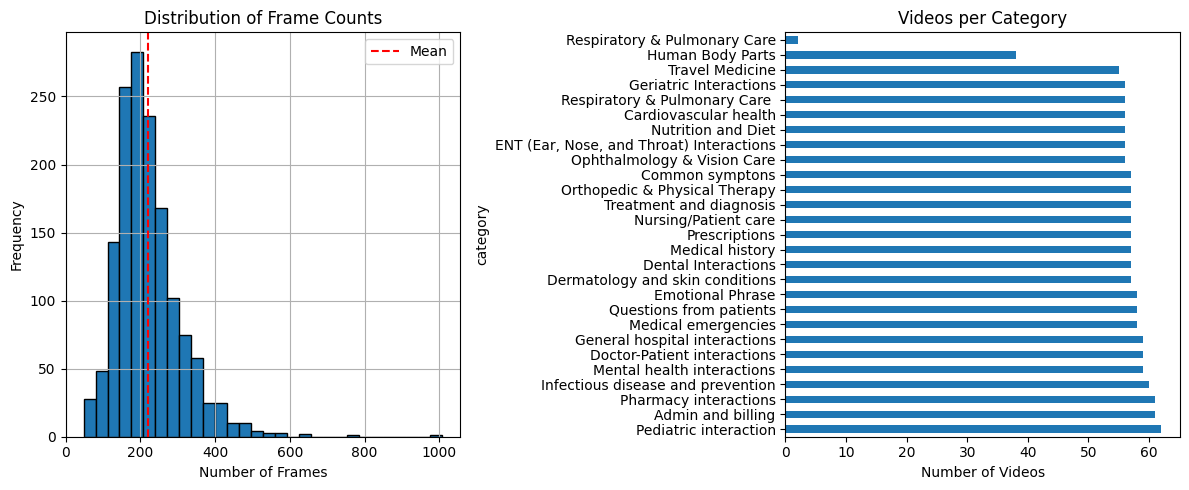

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Frame count distribution
plt.subplot(1, 2, 1)
df_processed['num_frames'].hist(bins=30, edgecolor='black')
plt.xlabel('Number of Frames')
plt.ylabel('Frequency')
plt.title('Distribution of Frame Counts')
plt.axvline(df_processed['num_frames'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()

# Category distribution
plt.subplot(1, 2, 2)
category_counts = df_processed['category'].value_counts()
category_counts.plot(kind='barh')
plt.xlabel('Number of Videos')
plt.title('Videos per Category')
plt.tight_layout()
plt.show()

## Test Load a Feature File

# Test loading a random .npy file
sample_row = df_processed.sample(1).iloc[0]

print(f"📹 Video: {sample_row['video_file']}")
print(f"📝 Sentence: {sample_row['sentence']}")
print(f"📋 Category: {sample_row['category']}")
print(f"🎬 Frames: {sample_row['num_frames']}")

# Load features
features = np.load(sample_row['feature_path'])
print(f"\n✅ Loaded features shape: {features.shape}")
print(f"   Expected: ({sample_row['num_frames']}, {PER_FRAME_FEATURES})")

# Check first frame
print(f"\n📊 First frame sample (first 10 values):")
print(features[0, :10])
print(f"   Min: {features.min():.4f}, Max: {features.max():.4f}")

In [11]:
# Test loading a random .npy file
sample_row = df_processed.sample(1).iloc[0]

print(f"📹 Video: {sample_row['video_file']}")
print(f"📝 Sentence: {sample_row['sentence']}")
print(f"📋 Category: {sample_row['category']}")
print(f"🎬 Frames: {sample_row['num_frames']}")
if 'detection_ratio' in sample_row:
    print(f"📈 Detection ratio: {sample_row['detection_ratio']:.2f}")
    print(f"👁️ Mean pose visibility: {sample_row['mean_visibility']:.2f}")

features = np.load(sample_row['feature_path'])
print(f"\n✅ Loaded features shape: {features.shape}")
print(f"   Expected: ({sample_row['num_frames']}, {PER_FRAME_FEATURES})")

print(f"\n📊 First frame sample (first 10 values):")
print(features[0, :10])
print(f"   Min: {features.min():.4f}, Max: {features.max():.4f}")

📹 Video: 3676C.mp4
📝 Sentence: Tell me if your daughter has trouble making decisions.
📋 Category: Pediatric interaction
🎬 Frames: 159
📈 Detection ratio: 1.00
👁️ Mean pose visibility: 0.72

✅ Loaded features shape: (159, 540)
   Expected: (159, 540)

📊 First frame sample (first 10 values):
[ 0.04467951 -1.6385214  -2.5943015   0.99886525  0.1000743  -1.804021
 -2.4995797   0.9965503   0.13867229 -1.8056867 ]
   Min: -4.5836, Max: 5.6153
